# Getting started with TensorFlow

This is taken from [Getting Started with TensorFlow ](https://www.tensorflow.org/get_started/get_started).
It covers the basic use of TensorFlow at its most basic level.

#### Importing TensorFlow
- TensorFlow is Python library.
- Python libraries are imported using an `import` statement.
- The things in TensorFlow must then be prefixed with `tensorflow`, e.g. `tensorflow.constant()`.
- To save us some typing we can include an `as` clause to the `import` statement, giving e.g. `tf.constant()`.

In [3]:
import tensorflow as tf

#### Data flow graphs

- TensorFlow thinks of computations as graphs.
- Starting nodes of the graph are data sources.
- Intermediate nodes are operations.
- Ending nodes are data outputs.

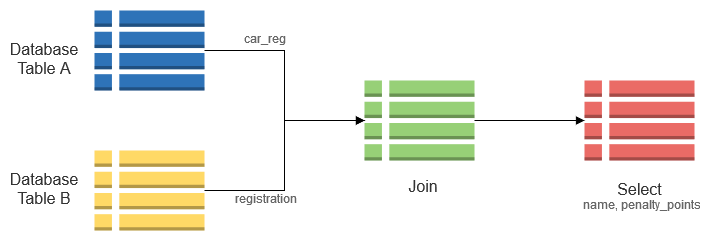

#### Creating data nodes

- We create nodes using functions like `tf.constant()`.
- They're just placeholders, until we `run` the graph later.

In [4]:
node1 = tf.constant(3.0, dtype=tf.float32)
node2 = tf.constant(4.0) # also tf.float32 implicitly
print(node1, node2)

Tensor("Const:0", shape=(), dtype=float32) Tensor("Const_1:0", shape=(), dtype=float32)


#### Running the session

- We create a session, which encapsulates an execution of the graph, creating a scope.
- Then we run the graph in the session.
- It's not very interesting, our graph just contains two separate, unconnected nodes.

In [5]:
sess = tf.Session()
print(sess.run([node1, node2]))

[3.0, 4.0]


#### Perform an operation
- Here we create an `add` node that adds its inputs.
- We tell it to use `node1` and `node2` as input.
- We now have three nodes, two containing constant numbers with data flowing from these to the third node which adds them.

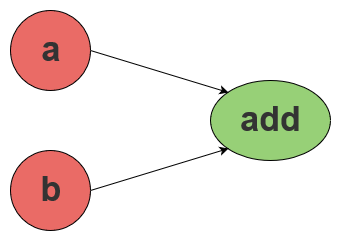

In [6]:
node3 = tf.add(node1, node2)
print("node3:", node3)
print("sess.run(node3):", sess.run(node3))

node3: Tensor("Add:0", shape=(), dtype=float32)
sess.run(node3): 7.0


#### Placeholder nodes
- Constants are fine, but what if we want to use variables?
- We use `tf.placeholder()`.

In [7]:
a = tf.placeholder(tf.float32)
b = tf.placeholder(tf.float32)
adder_node = a + b  # + provides a shortcut for tf.add(a, b)

Now when we run the graph we supply the values of the placeholders.

In [8]:
print(sess.run(adder_node, {a: 3, b: 4.5}))
print(sess.run(adder_node, {a: [1, 3], b: [2, 4]}))

7.5
[ 3.  7.]


#### Implicit nodes
- TensorFlow is clever when it comes to syntax.
- We can create a fourth node that triples the value from `adder_node` implicitly.
- Think of this as operator overloading.

In [9]:
add_and_triple = adder_node * 3.0
print(sess.run(add_and_triple, {a: 3, b: 4.5}))

22.5


## Linear models with gradient descent
- Let's have a quick look at doing something more complicated with TensorFlow.
- We'll try to estimate the best line that fits the following data.
- You can probably guess that the best line should have slope -1 and intercept 1.
- Let's get TensorFlow to use a complicated algorithm to estimate this!

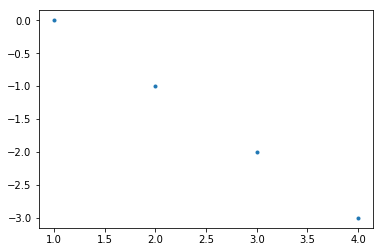

In [10]:
import matplotlib.pyplot as pl

x_vals = [1, 2, 3, 4]
y_vals = [0, -1, -2, -3]

pl.plot(x_vals, y_vals, '.')
pl.show()

#### Initialise some nodes
- We'll create two values with guess values to start.
- The first is `W`, and this will be the slope of the line.
- The second is `b` and this will be the value of `y` when `x` is zero (the intercept).
- We'll create a placeholder for our x values, called `x`.
- Then we'll create a "function" which multiplies the placeholder `x` by `W` (which is 0.3 to start) and then adds `b` (which is -0.3 to start).

In [11]:
W = tf.Variable([.3], dtype=tf.float32)
b = tf.Variable([-.3], dtype=tf.float32)
x = tf.placeholder(tf.float32)
linear_model = W * x + b

#### The goal
- Our goal will be to adjust `W` and `b` so that when we perform this "function" on our x values we get outputs that are close to our y values.
- Then `W` and `b` are good fits for our data.
- Let's get the session running.

In [12]:
init = tf.global_variables_initializer()
sess.run(init)

print(sess.run(linear_model, {x: [1, 2, 3, 4]}))

[ 0.          0.30000001  0.60000002  0.90000004]


#### Bad predictions
- Currently our predictions are not very good.
- We want the above values (`(W * x) + b`) to be close to our y value `[0, -1, -2, -3]`.
- To improve them, we must somehow quantify how bad our predictions are.
- The typical way to do this is to subtract our predictions from what we know the values should be, square each of those values and add them together. We call this *the sum of the squares*.
- Note a key idea here: we must *know* in advance what some of the `y` values should be. This is the *supervised* part of supervised learning. It's like we're teaching the model by giving it feedback on a test we give it.
- Let's tell TensorFlow how to quantify how bad the model is.

In [13]:
y = tf.placeholder(tf.float32)
squared_deltas = tf.square(linear_model - y)
loss = tf.reduc e_sum(squared_deltas) # indicates a cost function
print(sess.run(loss, {x: [1, 2, 3, 4], y: [0, -1, -2, -3]}))

23.66


#### Perfect fit
- Let's compare that loss to what we know is the perfect fit model, when `W` is -1 and `b` is 1.
- We can use the `tf.assign` function to temporarily assign these values.
- The loss is 0 then, as expected.
- Any other values for `W` and `b` will move the loss away from 0.
- Question: can the loss be less than 0? No it can't. Squering any number returns positive number.

In [14]:
fixW = tf.assign(W, [-1.])
fixb = tf.assign(b, [1.])
sess.run([fixW, fixb])
print(sess.run(loss, {x: [1, 2, 3, 4], y: [0, -1, -2, -3]}))

0.0


#### Optimisation
- Optimisation can be tricky, and there is a lot of theoretical stuff to go through.
- Luckily TensorFlow comes with built-in optimisation methods.
- You must understand how optimisations work to do them right.
- For now, let's just give them a whirl in the knowledge that they're more complex.
- One of the most popular optimisation methods is gradient descent, based on calculus.
- It works by making small changes in the parameters (`W` and `b`) in the right direction.

In [15]:
optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(loss)

#### Running the optimisation
- We run the optimiser 1000 times.
- With each iteration the values are getting closer and closer to some optimum.

In [30]:
sess.run(init) # reset values to incorrect defaults.
for i in range(400):
  sess.run(train, {x: [1, 2, 3, 4], y: [0, -1, -2, -3]})

print(sess.run([W, b, loss], {x: [1, 2, 3, 4], y: [0, -1, -2, -3]}))

[array([-0.99571204], dtype=float32), array([ 0.98739296], dtype=float32), 0.00010617806]


#### Visualise
Let's have a look at our fitted line (in red) compared the actual line (in blue).

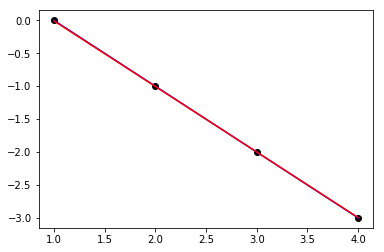

In [31]:
import numpy as np

W_est = W.eval(sess)
b_est = b.eval(sess)

x_vals = np.array([1, 2, 3, 4])
y_vals = np.array([0, -1, -2, -3])

pl.plot(x_vals, y_vals, 'ko')
pl.plot(x_vals, -1.0  * x_vals + 1.0,   'b-')
pl.plot(x_vals, W_est * x_vals + b_est, 'r-')

pl.show()

#### End